<a href="https://colab.research.google.com/github/mik-nn/Motion-Detection/blob/main/%D0%92%D1%8B%D1%87%D0%B8%D1%82%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%B0%D0%B4%D1%80%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Фрамеворк вывода видео в Colab
!pip install -U -q kora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.8 MB/s eta 0:00:00


In [2]:
def auth_drive():
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from oauth2client.client import GoogleCredentials as GC
    from google.colab import auth
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GC.get_application_default()
    return GoogleDrive(gauth)
auth_drive()

In [3]:
#Грузим данные
#!gdown  1hw1w-XMYCALrp5lZdLo2xktASiQChtNQ
!gdown  1hrWo4El4l92sjW9rGxMBNLBhoN_Ux4bK
#!unzip 1920x1080_19.826fps.zip
!unzip 640x320_25fps.zip

Downloading...
From: https://drive.google.com/uc?id=1hrWo4El4l92sjW9rGxMBNLBhoN_Ux4bK
To: /content/640x320_25fps.zip
100% 217M/217M [00:01<00:00, 146MB/s]
Archive:  640x320_25fps.zip
   creating: 640x320_25fps/
  inflating: 640x320_25fps/vid_19.40.mp4  
  inflating: 640x320_25fps/vid_20.11.mp4  
  inflating: 640x320_25fps/vid_13.05s.mp4  
  inflating: 640x320_25fps/vid_13.40s.mp4  


In [4]:
#Библиотеки
from IPython.display import clear_output
from google.colab import widgets
from ipywidgets import interact

In [2]:
# Проверка
video = '/content/640x320_25fps/vid_13.05s.mp4'
from IPython.display import HTML, clear_output
from kora.drive import upload_public
url = upload_public(video)
HTML(f"""<video src={url} width=500 controls/>""")

In [3]:
#Открываем mp4
from google.colab.patches import cv2_imshow
import os
import cv2
suffix='_sub.mp4'
out_name = video[:-4]+suffix
cap = cv2.VideoCapture(video)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
print(out_name)
if os.path.exists(out_name):
  os.remove(out_name)
out = cv2.VideoWriter(out_name,fourcc, fps, (width,height))


/content/640x320_25fps/vid_13.05s_sub.mp4


Image Similarity: 98.3357%
16412.0


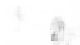

In [4]:
from collections import Counter
from skimage.metrics import structural_similarity
# Поиск Bounding Box по разнице кадров и оценки площади полученных кусочков
from google.colab.patches import cv2_imshow
DELTA_THRESH = 64
ret, img = cap.read()
#current_frame = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
previous_frame = img.copy()
# Разница в COUNT кадров
COUNT = 1
for i in range(COUNT):
  ret, img = cap.read()
  if not ret: break 
if ret:
  current_frame = img
# Уменюшаем изображение для сглаживания шумов
scale=8
while(cap.isOpened()):
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    previous_frame_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    dim = (width//scale,height//scale)
    current_frame_gray = cv2.resize(current_frame_gray,dim)    
    previous_frame_gray = cv2.resize(previous_frame_gray,dim) 
#    frame_diff = cv2.absdiff(current_frame,previous_frame)
#    frame_diff = cv2.subtract(current_frame_gray,previous_frame_gray)
    (score, diff) = structural_similarity(previous_frame_gray,
                                          current_frame_gray, full=True)
    print("Image Similarity: {:.4f}%".format(score * 100))

 #   diff_gray = frame_diff
    diff_gray = diff
    diff = (diff * 255).astype("uint8")
    frame_diff = cv2.merge([diff, diff, diff])
    diff_gray = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
#    thresh = cv2.threshold(
#        diff_gray, DELTA_THRESH, 255,
#        cv2.THRESH_BINARY)[1]
# для  structural_similarity
    thresh = cv2.threshold(
        diff_gray, 0, 255,
        cv2.THRESH_BINARY_INV| cv2.THRESH_OTSU)[1]
  #  thresh = cv2.dilate(thresh, None, iterations=2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if contours:
      for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        current_frame = cv2.rectangle(current_frame,(x*scale,y*scale),((x+w)*scale,(y+h)*scale),(0,255,0),2)
    out.write(current_frame)
    print(cap.get(cv2.CAP_PROP_POS_FRAMES))
    cv2_imshow(diff_gray)
    clear_output(wait=True)  
    previous_frame = current_frame.copy()
    for i in range(COUNT):
      ret, img = cap.read()
    if not ret: break
    if ret:
     current_frame = img
    else:
      break
#   current_frame = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
out.release()
cv2.destroyAllWindows()

In [5]:
!cp out_name '/content/drive/myDrive/Carpets'
url = upload_public(out_name)
HTML(f"""<video src={url} width=640 controls/>""")
!cp out_name '/content/drive/myDrive/Carpets'

cp: cannot stat 'out_name': No such file or directory


RedirectMissingLocation: ignored

In [ ]:
import cv2
import numpy as np

class VideoCaptureYUV:
    def __init__(self, filename, size):
        self.height, self.width = size
        self.frame_len = self.width * self.height * 3 / 2
        self.f = open(filename, 'rb')
        self.shape = (int(self.height*1.5), self.width)

    def read_raw(self):
        try:
            raw = self.f.read(self.frame_len)
            yuv = np.frombuffer(raw, dtype=np.uint8)
            yuv = yuv.reshape(self.shape)
        except Exception as e:
            print str(e)
            return False, None
        return True, yuv

    def read(self):
        ret, yuv = self.read_raw()
        if not ret:
            return ret, yuv
        bgr = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR_I420)
        return ret, bgr


if __name__ == "__main__":
    filename = "akiyo_cif.yuv"
    size = (288, 352)
    cap = VideoCaptureYUV(filename, size)

    while 1:
        ret, frame = cap.read()
        if ret:
            #cv2.imwrite("frame_"+str(i)+'.png', frame)
            cv2.imshow("frame", frame)
            cv2.waitKey(30)
        else:
            break

In [ ]:
import numpy  as np
print(video)
cap = cv2.VideoCapture(video)
cap.set(cv2.CAP_PROP_CONVERT_RGB, False) 
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out_v = video[:-4]+'_OptF.mp4'
out = cv2.VideoWriter(out_v,fourcc, fps, (width,height))

scale = 4
dim = (width//scale,height//scale)

ret, frame1 = cap.read()
frame1 = cv2.resize(frame1,dim)
#prev = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
prev = cv2.read()
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while True:
    ret, frame2 = cap.read()
    if not ret: break
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    

    next = cv2.resize(next,dim)
    flow = cv2.calcOpticalFlowFarneback(prev,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    #cv2_imshow('frame2',bgr)
    out.write(bgr)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    prev = next.copy()
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
from kora.drive import upload_public
out_v = '/content/640x320_25fps/13.05s_OptF.mp4'
url = upload_public(out_v)
HTML(f"""<video src={url} width=640 controls/>""")